# ResNet for MNIST in PyTorch

In [ ]:
!pip install torch torchvision pytorch-lightning

  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 32.8 MB/s  0:00:023.7 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 23.7 MB/s  0:00:00
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.8 MB/s  0:00:00
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18/18 [pytorch-lightning]0m 17/18 [pytorch-lightning]


In [12]:
import torch
torch.__version__

'2.8.0'

In [ ]:
# =============================
# Hyperparameters (Students: FILL THESE)
# =============================
# Convolution parameters for the first ResNet layer that processes MNIST images.
# - KERNEL_SIZE: size of the sliding window. Larger values see more context but can blur fine details.
# - STRIDE: step size of the window. Larger stride downsamples more aggressively (fewer output pixels).
# - PADDING: zeros added to borders so outputs keep more spatial size; larger padding preserves border information.
# Learning rate controls how big a step the optimizer takes; too high can diverge, too low can be slow.

# Students: set these four values. Examples are in the comments.
KERNEL_SIZE = None      # e.g., (3, 3), (5, 5), (7, 7)
STRIDE = None           # e.g., (1, 1) for minimal downsampling, or (2, 2)
PADDING = None          # e.g., (1, 1) for small padding, or (3, 3)
LEARNING_RATE = None    # e.g., 1e-3, 5e-3, 1e-2


In [1]:
from torchvision.models import resnet18
from torch import nn
from torch.utils.data import DataLoader

In [2]:
model = resnet18(num_classes=10)

In [5]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Replace the first convolution to accept MNIST 1-channel images using student hyperparameters
# KERNEL_SIZE: receptive field size; STRIDE: downsampling factor; PADDING: border handling
assert 'KERNEL_SIZE' in globals() and 'STRIDE' in globals() and 'PADDING' in globals(), "Define KERNEL_SIZE, STRIDE, PADDING above"
assert KERNEL_SIZE is not None and STRIDE is not None and PADDING is not None, "Fill in KERNEL_SIZE, STRIDE, PADDING in the hyperparameters cell"
# Basic shape validation to teach good practices
assert isinstance(KERNEL_SIZE, tuple) and len(KERNEL_SIZE) == 2 and all(isinstance(v, int) and v > 0 for v in KERNEL_SIZE)
assert isinstance(STRIDE, tuple) and len(STRIDE) == 2 and all(isinstance(v, int) and v > 0 for v in STRIDE)
assert isinstance(PADDING, tuple) and len(PADDING) == 2 and all(isinstance(v, int) and v >= 0 for v in PADDING)
model.conv1 = nn.Conv2d(1, 64, kernel_size=KERNEL_SIZE, stride=STRIDE, padding=PADDING, bias=False)

In [ ]:
# DATA: MNIST dataset and transforms
# - MNIST has grayscale (1-channel) 28x28 images of handwritten digits 0-9
# - We use ToTensor to convert PIL images to torch tensors in [0,1]
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [ ]:
# Train and test splits. Setting download=True fetches the data if not present.
# transform=ToTensor converts images to shape [C,H,W] where C=1 for MNIST.
train_ds = MNIST("mnist", train=True, download=True, transform=ToTensor())
test_ds = MNIST("mnist", train=False, download=True, transform=ToTensor())

In [ ]:
# DataLoaders create mini-batches for training and evaluation
# - batch_size controls how many images per step (fits GPU/CPU memory)
# - shuffle=True for training improves SGD by mixing data
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64)

In [7]:
import pytorch_lightning as pl

In [ ]:
# LightningModule wraps training logic; students supply hyperparameters from the cell above
class ResNetMNIST(pl.LightningModule):
  def __init__(self, kernel_size, stride, padding, learning_rate):
    super().__init__()
    # Validate inputs early for a better teaching experience
    assert isinstance(kernel_size, tuple) and len(kernel_size) == 2 and all(isinstance(v, int) and v > 0 for v in kernel_size), "kernel_size must be a 2-int tuple"
    assert isinstance(stride, tuple) and len(stride) == 2 and all(isinstance(v, int) and v > 0 for v in stride), "stride must be a 2-int tuple"
    assert isinstance(padding, tuple) and len(padding) == 2 and all(isinstance(v, int) and v >= 0 for v in padding), "padding must be a 2-int tuple"
    assert isinstance(learning_rate, float) and learning_rate > 0, "learning_rate must be a positive float"

    # Save hyperparameters so checkpoints remember them
    self.save_hyperparameters()
  
    # Build the backbone
    self.model = resnet18(num_classes=10)
    # Swap first conv to accept 1-channel MNIST using student-chosen params:
    # - Larger kernel_size sees more context; too large may over-smooth
    # - Larger stride downsamples more; may lose detail
    # - More padding preserves borders; zero padding adds zeros around edges
    self.model.conv1 = nn.Conv2d(1, 64, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)

    self.loss = nn.CrossEntropyLoss()
    self.learning_rate = learning_rate

  def forward(self, x):
    return self.model(x)
  
  def training_step(self, batch, batch_no):
    # batch is a tuple of (images, labels)
    x, y = batch
    logits = self(x)
    loss = self.loss(logits, y)
    return loss
  
  def configure_optimizers(self):
    # RMSprop is a good baseline optimizer for CNNs; learning_rate chosen by students
    return torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)

In [ ]:
# Instantiate the LightningModule with hyperparameters from the student cell
# We assert they have been filled to guide students.
assert all(v is not None for v in (KERNEL_SIZE, STRIDE, PADDING, LEARNING_RATE)), "Fill in all hyperparameters first in the hyperparameters cell"
model = ResNetMNIST(kernel_size=KERNEL_SIZE, stride=STRIDE, padding=PADDING, learning_rate=LEARNING_RATE)

In [ ]:
# Trainer orchestrates the training loop
# - max_epochs: how many full passes over the training set
# - enable_progress_bar: show progress in notebooks/CLI
# - log_every_n_steps: how often to log metrics to the logger
trainer = pl.Trainer(
    max_epochs=1,
    enable_progress_bar=True,   # replaces progress_bar_refresh_rate
    log_every_n_steps=20        # controls logging frequency
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/advaittahilyani/anaconda3/envs/waferDetection/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [ ]:
# Kick off training: the trainer will call training_step repeatedly over mini-batches
trainer.fit(model, train_dl)


  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | ResNet           | 11.2 M | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.701    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode
/Users/advaittahilyani/anaconda3/envs/waferDetection/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 938/938 [00:32<00:00, 28.49it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 938/938 [00:33<00:00, 28.36it/s, v_num=1]


In [ ]:
# Save a checkpoint containing model weights and hyperparameters (via save_hyperparameters)
# Note: If you change hyperparameters, you should retrain before saving a new checkpoint.
trainer.save_checkpoint("resnet18_mnist.pt")

In [15]:
def get_prediction(x, model: pl.LightningModule):
  model.freeze() # prepares model for predicting
  probabilities = torch.softmax(model(x), dim=1)
  predicted_class = torch.argmax(probabilities, dim=1)
  return predicted_class, probabilities

In [16]:
from tqdm.autonotebook import tqdm

/var/folders/2z/mgq3br417bdf40vb82c4_vg80000gp/T/ipykernel_19828/987820437.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [ ]:
# Load from checkpoint; Lightning will restore hparams saved during training
# This means you don't need to pass kernel_size/stride/padding/learning_rate here
inference_model = ResNetMNIST.load_from_checkpoint("resnet18_mnist.pt")

In [18]:
true_y, pred_y = [], []
for batch in tqdm(iter(test_dl), total=len(test_dl)):
  x, y = batch
  true_y.extend(y)
  preds, probs = get_prediction(x, inference_model)
  pred_y.extend(preds.cpu())

100%|██████████| 157/157 [00:37<00:00,  4.19it/s]


In [19]:
from sklearn.metrics import classification_report

In [20]:
print(classification_report(true_y, pred_y, digits=3))

              precision    recall  f1-score   support

           0      0.985     0.991     0.988       980
           1      0.980     0.996     0.988      1135
           2      0.955     0.984     0.969      1032
           3      0.988     0.986     0.987      1010
           4      0.985     0.988     0.986       982
           5      0.975     0.991     0.983       892
           6      0.997     0.960     0.978       958
           7      0.977     0.976     0.976      1028
           8      0.983     0.957     0.970       974
           9      0.980     0.970     0.975      1009

    accuracy                          0.980     10000
   macro avg      0.980     0.980     0.980     10000
weighted avg      0.980     0.980     0.980     10000



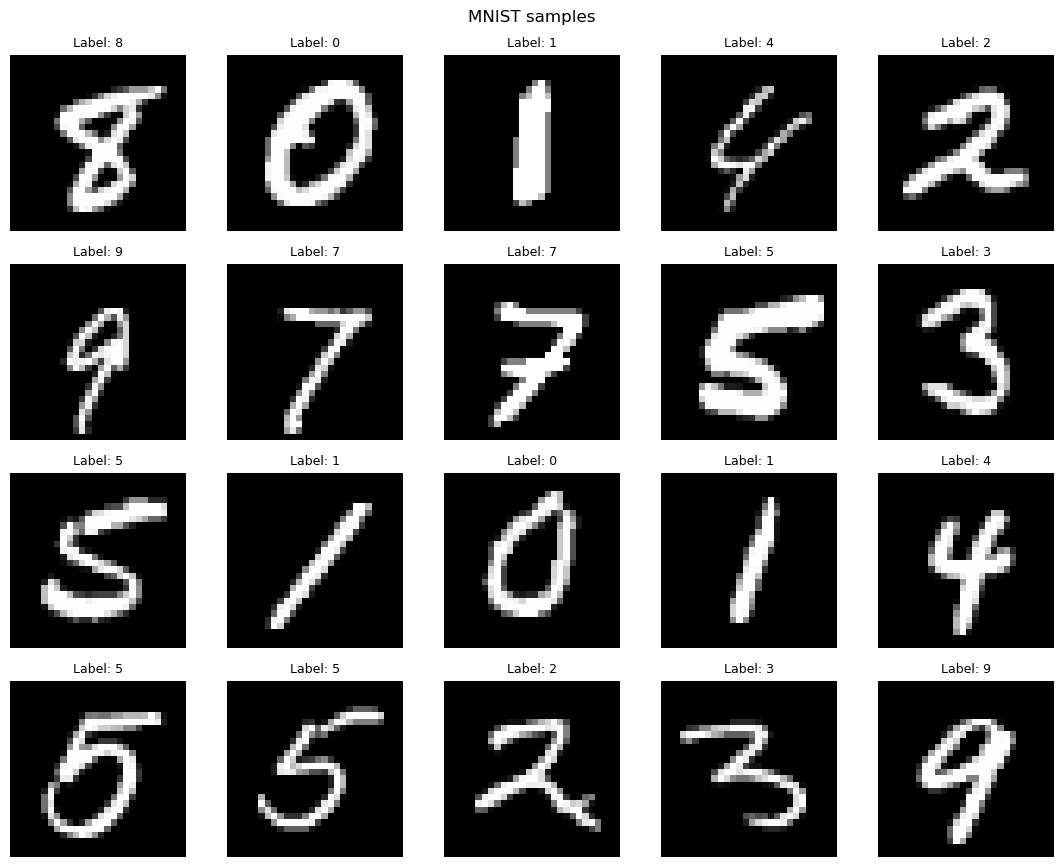

In [21]:
# MNIST dataset visualization (random samples)
import matplotlib.pyplot as plt
import random
import torch

# Dataset assertions and selection
assert 'test_ds' in globals() or 'train_ds' in globals(), "MNIST datasets not found"
ds = globals().get('test_ds', globals().get('train_ds'))
assert ds is not None and len(ds) > 0, "Dataset is missing or empty"

rows, cols = 4, 5
num_images = rows * cols
assert len(ds) >= num_images, f"Dataset too small for {num_images} samples"
indices = random.sample(range(len(ds)), num_images)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.2, rows * 2.2))
for i, idx in enumerate(indices):
  image, label = ds[idx]
  assert hasattr(image, 'shape'), "Sample image lacks shape"
  # Torchvision MNIST returns CHW tensors in [0, 1]
  assert isinstance(image, torch.Tensor), "Image must be a torch.Tensor"
  assert image.ndim in (2, 3), f"Unexpected image dims: {image.ndim}"
  if image.ndim == 3:
    assert image.shape[0] in (1, 3), f"Unexpected channels: {tuple(image.shape)}"
    img_np = image.squeeze(0).numpy() if image.shape[0] == 1 else image.permute(1, 2, 0).numpy()
    cmap = 'gray' if image.shape[0] == 1 else None
  else:
    img_np = image.numpy()
    cmap = 'gray'
  ax = axes[i // cols, i % cols]
  ax.imshow(img_np, cmap=cmap)
  ax.set_title(f"Label: {int(label)}", fontsize=9)
  ax.axis('off')

plt.suptitle("MNIST samples")
plt.tight_layout()
plt.show()


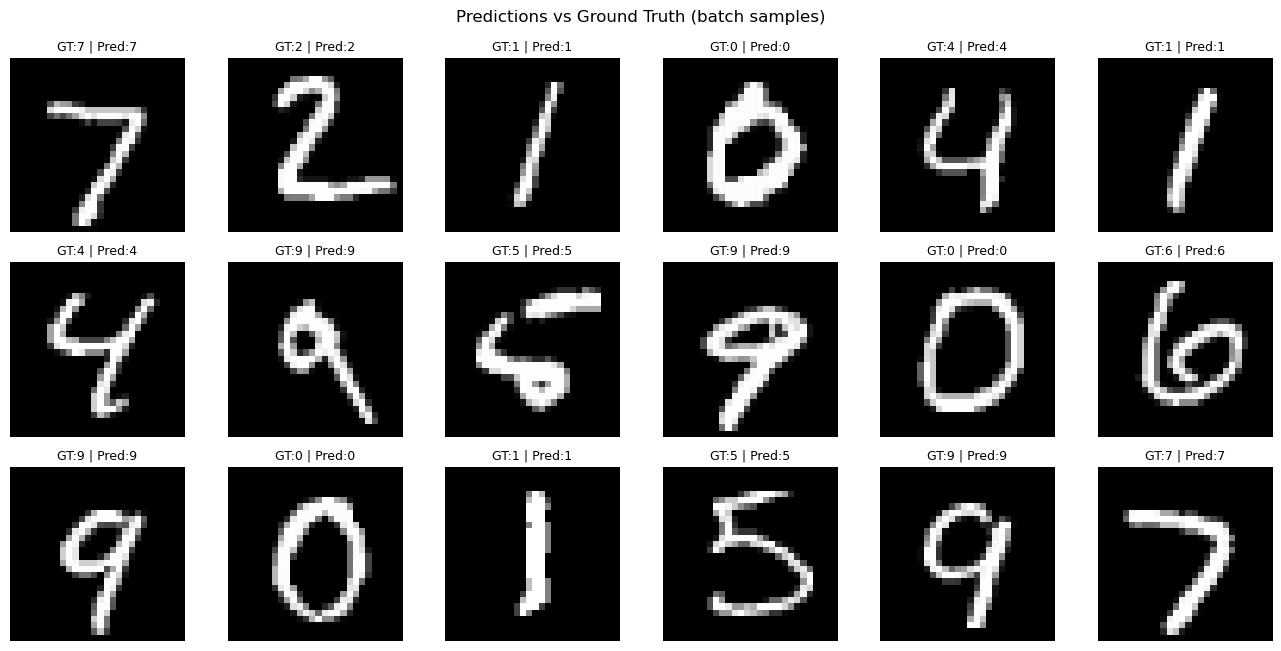

In [22]:
# Prediction visualization (model vs ground truth)
import matplotlib.pyplot as plt
import torch

assert 'inference_model' in globals(), "Missing 'inference_model'. Run the inference cell first."
assert 'test_dl' in globals(), "Missing 'test_dl' dataloader."
model = inference_model
model.freeze()

# Collect a single batch
batch_iter = iter(test_dl)
x_batch, y_batch = next(batch_iter)
assert isinstance(x_batch, torch.Tensor) and isinstance(y_batch, torch.Tensor), "Batch must be tensors"

with torch.no_grad():
  probs = torch.softmax(model(x_batch), dim=1)
  preds = torch.argmax(probs, dim=1)

rows, cols = 3, 6
num_images = rows * cols
assert x_batch.shape[0] >= num_images, f"Batch too small for {num_images} images"

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.2, rows * 2.2))
for i in range(num_images):
  img = x_batch[i]
  assert img.ndim in (3, 4), f"Unexpected img dims: {img.ndim}"
  if img.ndim == 3:
    assert img.shape[0] in (1, 3), f"Unexpected channels: {tuple(img.shape)}"
    img_np = img.squeeze(0).numpy() if img.shape[0] == 1 else img.permute(1, 2, 0).numpy()
    cmap = 'gray' if img.shape[0] == 1 else None
  else:
    img_np = img.squeeze().numpy()
    cmap = 'gray'
  ax = axes[i // cols, i % cols]
  ax.imshow(img_np, cmap=cmap)
  title = f"GT:{int(y_batch[i])} | Pred:{int(preds[i])}"
  if preds[i] != y_batch[i]:
    title = title + " ✗"
  ax.set_title(title, fontsize=9)
  ax.axis('off')

plt.suptitle("Predictions vs Ground Truth (batch samples)")
plt.tight_layout()
plt.show()
